Nama : Amrul Fadhil Yofan

Dataset : https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection

Source : Kaggle

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.preprocessing import text, sequence
import nltk
from collections import Counter

## Import Dataset dari Kaggle

In [2]:
!pip install -q kaggle

In [3]:
#Upload kaggle.json secara manual
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amrulfy","key":"8ec629e82333ebf8f0418507351abeda"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [6]:
# Download dataset
!kaggle datasets download -d bhavikjikadara/fake-news-detection

 98% 40.0M/41.0M [00:03<00:00, 18.2MB/s]
100% 41.0M/41.0M [00:03<00:00, 13.7MB/s]


In [7]:
# Unzip dan lihat list dataset
!mkdir news
!unzip fake-news-detection.zip -d news
!ls news

Archive:  fake-news-detection.zip
  inflating: news/fake.csv           
  inflating: news/true.csv           
fake.csv  true.csv


In [8]:
#Import data
df_fake = pd.read_csv('news/fake.csv')
df_true = pd.read_csv('news/true.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Analisis Data dan Cleaning Data

In [10]:
#Cek ukuran data
print(df_fake.shape)
print(df_true.shape)

(23481, 4)
(21417, 4)


In [11]:
#Cek data kosong
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [12]:
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Tujuan submission ini adalah untuk memprediksi suatu teks berita apakah asli atau palsu. Dalam hal ini, dua dataset yang berbeda akan digabung dan diberi label terlebih dahulu.

**Label**

0 untuk berita palsu

1 untuk berita asli

In [13]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [14]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [17]:
df_fake['label'] = 0
df_fake = df_fake.drop(columns=['date', 'subject'])
df_fake

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0


In [18]:
df_true['label'] = 1
df_true = df_true.drop(columns=['date', 'subject'])
df_true

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [21]:
#Menggabungkan dua dataset
df = pd.concat([df_fake, df_true])
df

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [28]:
df['label'].value_counts()

0    23481
1    21417
Name: label, dtype: int64

In [23]:
df['all_text'] = df['title'] + " " + df['text']
df

,title,text,label,all_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0,Pope Francis Just Called Out Donald Trump Dur...
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1,'Fully committed' NATO backs new U.S. approach...
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1,LexisNexis withdrew two products from Chinese ...
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1,Minsk cultural hub becomes haven from authorit...
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1,Vatican upbeat on possibility of Pope Francis ...


In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
#Menghapus stopwords dan teks yang tidak terlalu penting

stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Menghapus square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Menghapus URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)

#Menghapus stopwords dari text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stwd:
            final_text.append(i.strip())
    return " ".join(final_text)

#Menghapus keseluruhan (noisy text)
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text

df['all_text'] = df['all_text'].apply(denoise_text)

<ipython-input-26-4f1901b148ec>:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [27]:
#Mendeteksi jumlah kata
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df['all_text'])
corpus[:10]

#Jumlah kata yang sering ditemukan
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 111486,
 'said': 93161,
 'would': 54610,
 'U.S.': 50430,
 'President': 33171,
 'people': 33115,
 'also': 30325,
 'one': 29371,
 'Donald': 27796,
 'said.': 26195}

## Split Data

In [31]:
length = df['all_text'].str.len().max()
length

40192

In [29]:
text = df['all_text'].values
label = df['label'].values

In [32]:
#Split dataset 20%
x_train,x_test,y_train,y_test = train_test_split(text, label,test_size = 0.2, random_state=42)

In [44]:
print(x_train)

["Turkey's Erdogan says U.S. Jerusalem decision tramples law ATHENS (Reuters) Turkish President Tayyip Erdogan said Thursday U.S. President Donald Trump unfortunate decision recognize Jerusalem capital Israel trampling international laws Erdogan speaking Athens talks Prime Minister Alexis Tsipras, also said Turkey wanted see lasting solution island Cyprus, said Greek Cypriots avoiding talks."
 'BREAKING: Trump Reportedly Considering Ted Cruz Top Cabinet Position Ted Cruz would fair, honest all, would follow law. would hands one best choices position President-elect Donald Trump considering nominating Texas Senator Ted Cruz serve U.S. attorney general, according person familiar matter.Cruz, 45, Trump Tower New York Tuesday. approached reporters way out, Cruz said election mandate change say consideration job.Cruz unsuccessfully sought Republican presidential nomination. Trump odds primary, viciously attacking one another. Trump nicknamed Cruz Lyin Ted. Cruz endorse Trump speech Republic

In [45]:
print(x_test)

['Ben Stein Calls 9th Circuit Court: Committed ‘Coup d’état’ Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also Hollywood fame appearing TV shows films Ferris Bueller Day Off) made provocative statements Judge Jeanine Pirro show recently. discussing halt imposed President Trump Executive Order travel. Stein referred judgement 9th Circuit Court Washington state Coup tat executive branch constitution. Stein went call Judges Seattle political puppets judiciary political pawns. Watch interview complete statements note stark contrast rhetoric leftist media pundits neglect note court ever blocked Presidential orders immigration past discuss legal efficacy halt actual text Executive Order.READ TRUMP NEWS AT: 21st Century Wire Trump FilesSUPPORT WORK SUBSCRIBING BECOMING MEMBER @21WIRE.TV'
 'Trump drops Steve Bannon National Security Council WASHINGTON (Reuters) U.S. President Donald Trump removed chief strategist Steve Bannon National Security

In [46]:
print(y_train)
print(y_test)

[1 0 1 ... 1 0 0]
[0 1 1 ... 0 0 0]


##Tokenization dan Padding Sequence

In [33]:
max_len = 40
trunc_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=length, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
pad_train = pad_sequences(sequences_train, maxlen=max_len, truncating=trunc_type)
pad_test = pad_sequences(sequences_test, maxlen=max_len, truncating=trunc_type)

print(pad_train.shape)
print(pad_test.shape)

(35918, 40)
(8980, 40)


In [34]:
pad_train

array([[10735,  1649,    70, ..., 11830, 16716,    13],
       [ 1122,     2,  1793, ...,   356,   137,    68],
       [    2,   206,     1, ...,  1097,   128,   150],
       ...,
       [  857,  1220,   837, ...,    83,   123,  1692],
       [    2,  5826,   638, ..., 15013, 17424,  1942],
       [ 1122,    39,  1321, ...,    76,   825,  2932]], dtype=int32)

In [35]:
pad_test

array([[ 1704,  2887,   533, ...,  8885,   151,   624],
       [    2,  5739,  1439, ..., 10814,   754,    24],
       [ 1258,  1563,  3564, ...,   111,   677,  1276],
       ...,
       [ 4967,  2489,   773, ...,   167,  6664,   447],
       [  163,  6615,   594, ...,    10,  2150,    19],
       [    0,     0,     0, ...,     1,     1,    76]], dtype=int32)

## Modelling

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=length, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer='Adam', metrics=['accuracy'], loss='binary_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 64)            2572288   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

In [41]:
#Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\n Akurasi > 90% sehingga iterasi dihentikan")
callbacks = myCallback()

In [42]:
num_epochs = 50
history = model.fit(pad_train, y_train, epochs=num_epochs, validation_data=(pad_test, y_test), verbose=2, batch_size=128, callbacks=[callbacks])

Epoch 1/50

 Akurasi > 90% sehingga iterasi dihentikan
281/281 - 35s - loss: 0.0660 - accuracy: 0.9693 - val_loss: 0.0399 - val_accuracy: 0.9981 - 35s/epoch - 125ms/step


Karena hanya membutuhkan 1 Epoch, maka grafik loss & accuracy di bawah bisa diabaikan.

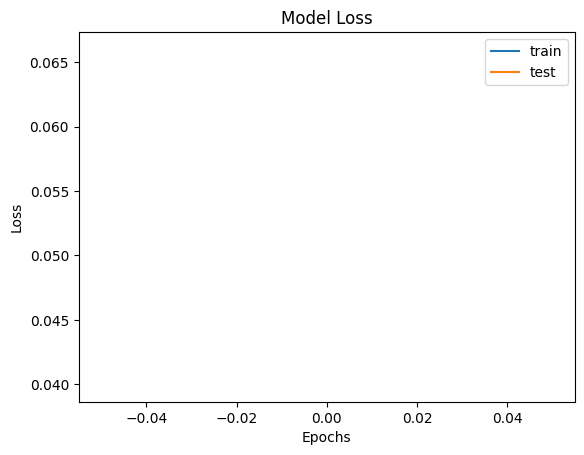

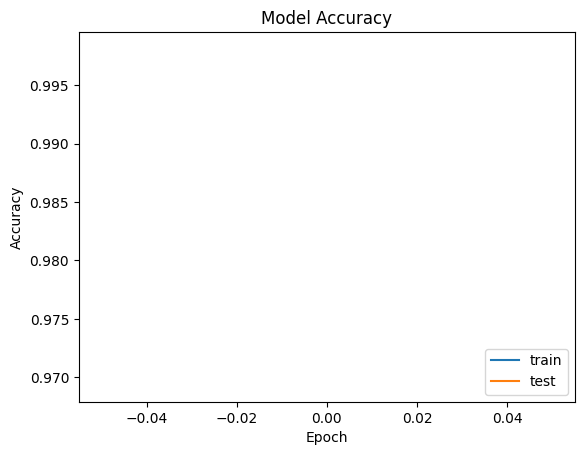

In [43]:
# Grafik Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

# Grafik Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()